In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from pytrends import dailydata
import requests
import collections
import os

from sklearn import linear_model
import statsmodels.api as sm

from backtesting import Backtest

from scipy.optimize import minimize


/opt/anaconda3/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Intro
We will implement [this paper](https://www.nature.com/articles/srep01684.pdf) by Preis, Moat, and Stanley and make modifications to their algorithm logic that will be detailed later.

## Data Collection and Processing
We sourced our alternative data from [Google Trends](https://trends.google.com/trends/?geo=US). Downloading data over a long time frame from the Google Trends website gives weekly datapoints with dates that are hard to control. To work around this, we used the third-party [pytrends](https://pypi.org/project/pytrends/) API for Python. This API allows us to request daily data for any time interval.

For our financial data we used yfinance because of its ease of use. Because our trading intervals will be on the scale of days-weeks,  

### Problems
Because the API is third-party, you will get 429 (too many requests) errors after about 3 years of daily data. We created a script that downloads and saves Google search trend data and ran it in a Kaggle Docker Container to save time.

Another problem is how the search volume values are computed by Google. Google samples a subset of its servers for the volume data. As a result, there are small variations between different requests with the same parameters. We determined that the difference was negligible to the overall trends although this could be looked into more thoroughly.


In [12]:
x = os.walk("trends")
for word in x:
    tuplee = word
words = tuplee[2]

In [13]:
start_year = 2010
start_month = 1
end_year = 2018
end_month = 12
index = "NDAQ"

training_index = yf.download(index, start = str(start_year)+"-"+str(start_month)+"-01", end = str(end_year)+"-"+str(end_month)+"-01")

[*********************100%***********************]  1 of 1 completed


In [14]:
start_year = 2019
start_month = 1
end_year = 2020
end_month = 11
index = "NDAQ"

testing_index = yf.download(index, start = str(start_year)+"-"+str(start_month)+"-01", end = str(end_year)+"-"+str(end_month)+"-01")

[*********************100%***********************]  1 of 1 completed


In [15]:
def getStats(key_word, start_year, start_month, end_year, end_month, index_data):
    #trend = pd.DataFrame(dailydata.get_daily_data(key_word, start_year, start_month, end_year, end_month, wait_time = 0)[key_word])
    trend = pd.read_csv("trends/"+key_word)
    key_word = key_word[:-4]
    trend['date'] = pd.to_datetime(trend['date'])
    trend = trend.set_index('date')
    trend["change"] = trend[key_word].pct_change()

    # join trend data with DJIA data
    joined = trend.merge(index_data, left_on = trend.index, right_on = index_data.index)
    joined = joined.rename(columns = {"key_0": "Date"})

    # grab the adj close price difference for each day
    #joined['Diff'] = joined['Adj Close'].diff()
    joined = joined.set_index(joined['Date'])

    joined["change moving avg"] = joined["change"].rolling("14d", min_periods = 1).mean()
    joined = joined[joined.index.dayofweek == 1]
    
    return joined


In [16]:
# grab data from yfinance and merge with la
training = {}

#for word in words:
for word in words:
    if word[0] == ".": # extra thing in there
        continue
    training[word] = getStats(word, start_year, start_month, end_year, end_month, training_index)

In [17]:
# testing data
testing = {}

for word in words:
    if word[0] == ".": # extra thing in there
        continue
    testing[word] = getStats(word, start_year, start_month, end_year, end_month, testing_index)

# EDA
Our downloaded Google Trends DataFrame looks like this.

In [29]:
training["returns.csv"].head()

,Date,returns_unscaled,returns_monthly,isPartial,scale,returns,change,Open,High,Low,Close,Adj Close,Volume,change moving avg
Date,,,,,,,,,,,,,,
2010-01-05,2010-01-05,54,34.0,NaN,0.34,18.36,-0.100000,19.930000,20.320000,19.930000,20.299999,17.419601,1481700,-0.023684
2010-01-12,2010-01-12,51,34.0,NaN,0.34,17.34,0.133333,20.160000,20.299999,19.820000,19.930000,17.102102,1732800,0.027288
2010-01-19,2010-01-19,100,34.0,NaN,0.34,34.00,0.587302,20.160000,20.240000,20.040001,20.129999,17.273724,1052300,0.108292
2010-01-26,2010-01-26,56,34.0,NaN,0.34,19.04,-0.111111,18.150000,18.430000,18.100000,18.100000,15.531766,2569300,0.040744
2010-02-02,2010-02-02,85,33.0,NaN,0.33,28.05,-0.150000,18.459999,18.719999,18.400000,18.580000,15.943654,1849600,0.034571


We are primarily interested in the last column which gives the scaled search volume. The other columns are used to calculate the scaling.

# Training

### We begin backtesting our model using the python backtesting library. 
### Our algorithm is as follows:
1. We have already calculated the change moving average. If that value is above some "high" threshold, then we buy at the current value. The intuition being that an increase in search volume on positive words will lead to a positive impact on the market and a increased price in our index. Vice versa for "low" threshold.
2. Now, we need to define some threshold at which to execute our buy and sell trades. We optimize our backtest (on all words available) to find the best values for our "high" and "low" parameters to optimize returns. 
3. We get our 80-20 split by grabbing the first 8 years (2010-2018) as our training data and the next two years (2019-2020) as our testing.
4. We run our testing model to find the optimized high and low thresholds.

In [19]:
def getMovingAvg(df):
    return pd.Series(df['change moving avg'])

In [20]:
from backtesting import Strategy
from backtesting.lib import crossover

class trainingStrat(Strategy):
    high = 0
    low = 0
    
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
        high = self.high
        low = self.low

    def next(self):
        if self.change[-1] > self.high:
            self.position.close()
            #print("buying")
            self.buy()

        elif self.change[-1] < self.low:
            self.position.close()
            #print("selling")
            self.sell()
        else:
            self.position.close()

In [22]:
%%time
# optimizing each word and saving best parameters high and low
training_stats = {}
training_bts = {}

for word in training.keys():
    bt = Backtest(training[word], trainingStrat, cash=100_000_000, commission=0)
    stats = bt.optimize(low = list(np.asarray(range(-10, 21, 2))/100),
                        high = list(np.asarray(range(-10, 21, 2))/100), 
                        constraint = lambda param: param.low < param.high, 
                        maximize = 'Equity Final [$]',
                        return_optimization = True, method = 'skopt',
                        random_state = 42)
    #stats = bt.run()
    training_stats[word] = stats
    training_bts[word] = bt
    print("Finished "+word)
    
training_stats

Finished housing.csv
Finished chance.csv
Finished stock market.csv
Finished politics.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divid

Finished cash.csv
Finished invest.csv
Finished dividend.csv
Finished hedge.csv
Finished gold.csv
Finished bonds.csv
Finished finance.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divid

Finished culture.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished economy.csv
Finished short sell.csv
Finished leverage.csv
Finished conflict.csv
Finished risk.csv
Finished nasdaq.csv
Finished banking.csv
Finished derivatives.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished sell.csv
Finished office.csv
Finished portfolio.csv
Finished dow jones.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished food.csv
Finished revenue.csv
Finished economics.csv
Finished fine.csv
Finished holiday.csv
Finished credit.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divid

Finished society.csv
Finished crash.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished profit.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished water.csv
Finished money.csv
Finished tourism.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divid

Finished growth.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divid

Finished arts.csv
Finished color.csv
Finished rich.csv
Finished fed.csv
Finished energy.csv
Finished investment.csv
Finished debt.csv
Finished earnings.csv
Finished present.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished loss.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished house.csv
Finished financial markets.csv
Finished markets.csv
Finished consumption.csv
Finished crisis.csv
Finished inflation.csv
Finished train.csv
Finished ore.csv
Finished short selling.csv
Finished transaction.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished buy.csv
Finished freedom.csv
Finished gains.csv
Finished world.csv
Finished oil.csv
Finished metals.csv
Finished war.csv
Finished unemployment.csv
Finished health.csv


/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/opt/anaconda3/lib/python3.8/site-packages/backtesting/backtesting.py:1579: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip(annualized_return / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Finished travel.csv
Finished return.csv
Finished returns.csv
Finished stocks.csv


NameError: name 'optimized_stats' is not defined

In [203]:
# unpack the various values held within the optimized stats
returns = {}
sharpe = {}
win_rate = {}
avg_trade = {}
optimized_parameters = {}

for word in training.keys():
    returns[word] = training_stats[word][0][6]
    returns['BUY AND HOLD.csv'] = training_stats[word][0][7]
    sharpe[word] = training_stats[word][0][10]
    win_rate[word] = training_stats[word][0][18]
    avg_trade[word] = training_stats[word][0][21]
    optimized_parameters[word] = training_stats[word][1].x

In [204]:
optimized_words = [i[0] for i in sorted(returns.items(), key = lambda x: x[1], reverse = True)]
optimized_words_returns = sorted(returns.items(), key = lambda x: x[1], reverse = True)
returns_data = {'Key Word': [i[:-4] for i in optimized_words], 'Returns (%)': [i[1] for i in optimized_words_returns]}
training_returns = pd.DataFrame(returns_data)
training_returns = training_returns.set_index('Key Word')
training_returns.head(10)

,Returns (%)
Key Word,
returns,659.395428
chance,648.341014
debt,631.934267
gains,607.837710
rich,579.265036
crisis,526.189516
invest,507.587202
bonds,483.583745
culture,482.595006


In [205]:
training_returns[training_returns.index == "BUY AND HOLD"]

,Returns (%)
Key Word,
BUY AND HOLD,340.689667


In [206]:
optimized_words_sharpe = sorted(sharpe.items(), key = lambda x: x[1], reverse = True)
optimized_words.remove("BUY AND HOLD.csv")
sharpe_data = {'Key Word': [i[:-4] for i in optimized_words], 'Sharpe Ratio': [i[1] for i in optimized_words_sharpe]}
training_sharpe = pd.DataFrame(sharpe_data)
training_sharpe = training_returns.set_index('Key Word')
training_sharpe.head(10)

,Sharpe Ratio
Key Word,
returns,1.468046
chance,1.358257
debt,1.336228
gains,1.295350
rich,1.289471
crisis,1.281440
invest,1.280002
bonds,1.276603
culture,1.269180


In [216]:
optimized_words_parameters = {word:optimized_parameters[word] for word in optimized_words}
parameters_data = {'Key Word': [i[:-4] for i in optimized_words_parameters.keys()], 'Low Value': [i[1][0] for i in optimized_words_parameters.items()], 
                   'High Value': [i[1][1] for i in optimized_words_parameters.items()]}
parameters_df = pd.DataFrame(parameters_data)
parameters_df = parameters_df.set_index('Key Word')
parameters_df.head(10)

,Low Value,High Value
Key Word,,
returns,-0.022734,-0.019026
chance,-0.032021,-0.030074
debt,0.014744,0.025391
gains,-0.020545,0.003185
rich,-0.069404,-0.038873
crisis,-0.040839,-0.004754
invest,-0.060147,0.006458
bonds,-0.008160,0.000963
culture,-0.040031,-0.007301


# Testing

In [259]:
# all positive words here have sharpe ratio > 1,
"""
testing_words = ["invest.csv", "money.csv", "financial markets.csv", "bonds.csv", "stocks.csv", 
        "gains.csv", "derivatives.csv", "gold.csv", "dividend.csv", "rich.csv","revenue.csv", 
        "returns.csv", "nasdaq.csv", "dow jones.csv", "profit.csv", "economy.csv", "growth.csv",
       "investment.csv", "markets.csv", "banking.csv", "earnings.csv", "return.csv", "chance.csv", 
        "cash.csv"]
"""
testing_words = training.keys()

In [260]:
# slight modifications to testing dfs to let backtesting work
for word in testing_words:
    testing[word]['word'] = str(word)

In [261]:
from backtesting import Strategy
from backtesting.lib import crossover

def getMovingAvg(df):
    return pd.Series(df['change moving avg'])

def getOptimizedParameters(df):
    return optimized_parameters[df['word'][0]]

class testingStrat(Strategy):
    
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
        self.optimized_parameters = getOptimizedParameters(self.data) # grabs the word from the df, had to add a new column with name
        #print(self.optimized_parameters)
        self.low = self.optimized_parameters[0]
        self.high = self.optimized_parameters[1]
        
    def next(self):
        if self.change[-1] > self.high:
            self.position.close()
            #print("buying")
            self.buy()

        elif self.change[-1] < self.low:
            self.position.close()
            #print("selling")
            self.sell()
        else:
            self.position.close()

In [262]:
# testing
testing_stats = {}
testing_bts = {}
for word in testing_words:
    bt = Backtest(testing[word], testingStrat, cash=100_000_000, commission=0)
    stats = bt.run() # we no longer optimize, but we run and grab the optimized parameters from training
    testing_stats[word] = stats
    testing_bts[word] = bt

In [355]:
# unpack the various values held within the stats
testing_returns = {}
testing_sharpe = {}
testing_win_rate = {}
testing_avg_trade = {}

for word in testing_words:
    testing_returns[word] = testing_stats[word][6]
    testing_returns["BUY AND HOLD.csv"] = testing_stats[word][7]
    testing_sharpe[word] = testing_stats[word][10]
    testing_win_rate[word] = testing_stats[word][18]
    testing_avg_trade[word] = testing_stats[word][21]

In [356]:
testing_optimized_words = [i[0] for i in sorted(testing_returns.items(), key = lambda x: x[1], reverse = True)]
testing_optimized_words_returns = sorted(testing_returns.items(), key = lambda x: x[1], reverse = True)

In [357]:
testing_optimized_words_returns
returns_data = {'Key Word': [i[:-4] for i in testing_optimized_words], 'Returns (%)': [i[1] for i in testing_optimized_words_returns]}
testing_returns = pd.DataFrame(returns_data)
testing_returns = testing_returns.set_index('Key Word')
testing_returns.head(10)

,Returns (%)
Key Word,
short selling,92.539797
housing,81.078148
world,73.300619
energy,61.184470
cash,60.348321
BUY AND HOLD,57.200296
health,54.329161
gold,52.601553
gains,52.524847


In [358]:
testing_sharpe_words = sorted(testing_sharpe.items(), key = lambda x: x[1], reverse = True)
sharpe_data = {'Key Word': [i[0][:-4] for i in testing_sharpe_words], 'Sharpe Ratio': [i[1] for i in testing_sharpe_words]}
testing_sharpe = pd.DataFrame(sharpe_data)
testing_sharpe = testing_sharpe.set_index('Key Word')
testing_sharpe.head(10)

,Sharpe Ratio
Key Word,
world,1.347913
energy,1.286379
cash,1.271412
gold,1.186304
crash,1.180941
housing,1.174044
gains,1.172781
health,1.168261
leverage,1.160069


In [359]:
testing_bts[testing_optimized_words[0]].plot()

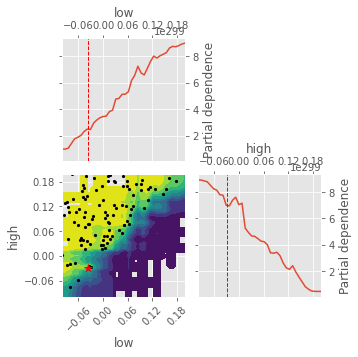

In [422]:
import skopt.plots 
x = skopt.plots.plot_objective(training_stats[testing_optimized_words[0]][1])

## Random Strategy Implementation and Comparison with Buy and Hold

In [361]:
import random

# randomly buy and sell 
class randomStrat(Strategy):
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
    def next(self):
        if random.choice([True, False]):
            self.position.close()
            self.buy()
        else:
            self.position.close()
            self.sell()

In [362]:
random_returns = []
best_word = testing_optimized_words[0]

for i in range(1000):
    bt = Backtest(testing[best_word], randomStrat, cash=100_000_000, commission=0) 
    random_stats = bt.run()
    random_returns.append(random_stats[6])
    
random_mean = np.mean(random_returns)
random_sd = np.std(random_returns)
random_plus = random_mean + random_sd
random_minus = random_mean - random_sd

returns_data['Key Word'].append('RANDOM')
returns_data['Key Word'].append('RANDOM + 1SD')
returns_data['Key Word'].append('RANDOM - 1SD')
returns_data['Returns (%)'].append(random_mean)
returns_data['Returns (%)'].append(random_plus)
returns_data['Returns (%)'].append(random_minus)

In [382]:
random_df = pd.DataFrame(returns_data)
random_df = random_df.sort_values(by=['Returns (%)'], ascending = False)
random_df = random_df.set_index('Key Word')
random_df.head(10)

,Returns (%)
Key Word,
short selling,92.539797
housing,81.078148
world,73.300619
energy,61.184470
cash,60.348321
BUY AND HOLD,57.200296
health,54.329161
gold,52.601553
gains,52.524847


In [384]:
random_df[random_df.index.str.contains("RANDOM")]

,Returns (%)
Key Word,
RANDOM + 1SD,47.752392
RANDOM,-0.457337
RANDOM - 1SD,-48.667067


<BarContainer object of 74 artists>

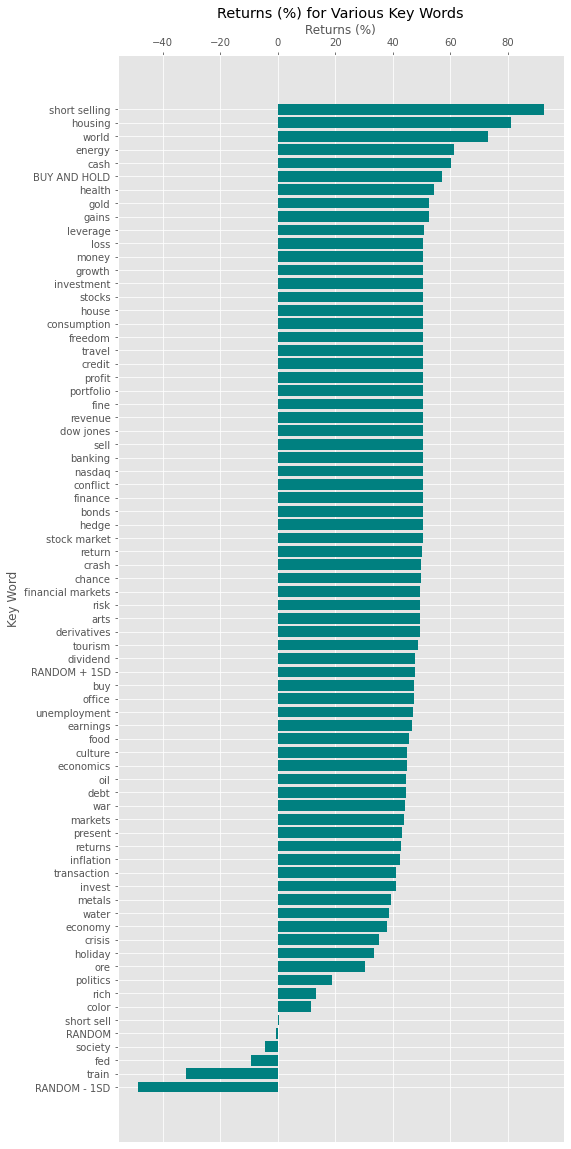

In [381]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (8,20))

flipped = random_df.reindex(index = random_df.index[::-1])

plt.style.use('ggplot')
plt.title("Returns (%) for Various Key Words")
plt.ylabel("Key Word")
plt.xlabel("Returns (%)")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.barh(data = flipped, width = "Returns (%)", y = flipped.index, color='teal', align = 'center')

<BarContainer object of 70 artists>

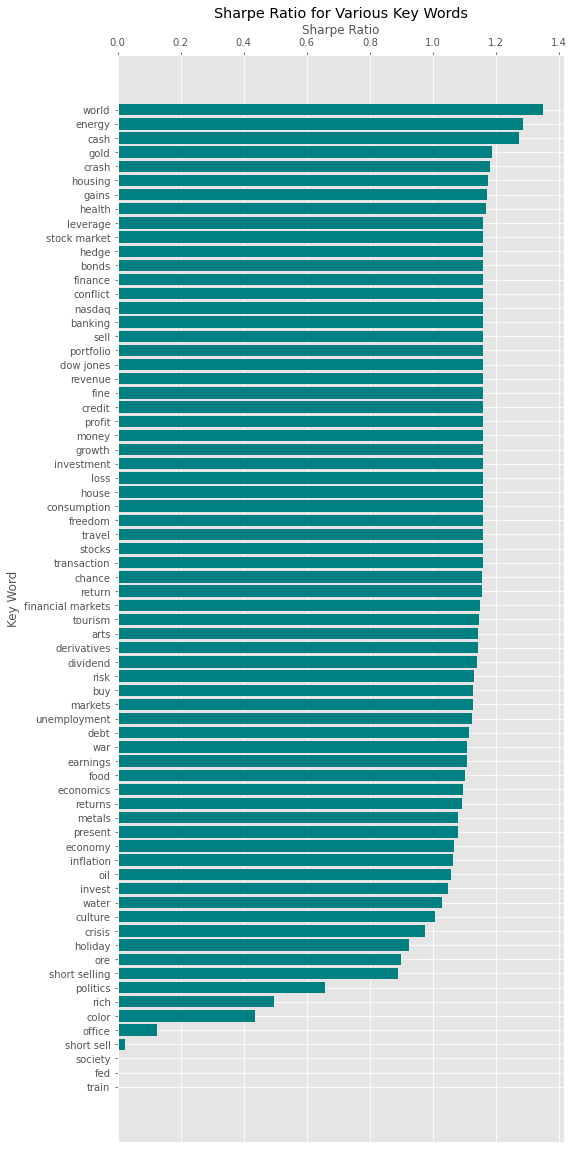

In [322]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (8,20))

flipped = testing_sharpe.reindex(index = testing_sharpe.index[::-1])

plt.style.use('ggplot')
plt.title("Sharpe Ratio for Various Key Words")
plt.ylabel("Key Word")
plt.xlabel("Sharpe Ratio")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.barh(data = flipped, width = "Sharpe Ratio", y = flipped.index, color='teal', align = 'center')

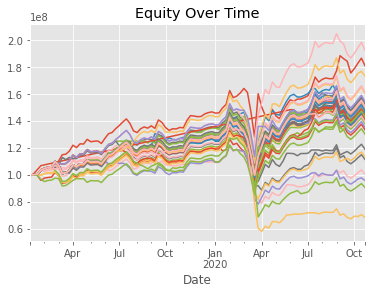

In [245]:
for word in list(training.keys()):
    stat = testing_stats[word]
    stat["_equity_curve"]['Equity'].plot()
x=plt.title('Equity Over Time')

In [402]:
random_rolling_mean_and_sd = pd.DataFrame()
best_word = testing_optimized_words[0]
n = 10
for i in range(n):
    bt = Backtest(testing[best_word], randomStrat, cash=100_000_000, commission=0) 
    random_stats = bt.run()
    random_returns.append(random_stats[6])
    if i == 0:
        random_rolling_mean_and_sd["sum"] = random_stats["_equity_curve"]['Equity']
        random_rolling_mean_and_sd["sumsq"] = random_stats["_equity_curve"]['Equity']**2
    else:
        random_rolling_mean_and_sd["sum"] = random_rolling_mean_and_sd["sum"] + random_stats["_equity_curve"]['Equity']
        random_rolling_mean_and_sd["sumsq"] = random_rolling_mean_and_sd["sumsq"] + random_stats["_equity_curve"]['Equity'] ** 2
    
random_rolling_mean_and_sd["mean"] = random_rolling_mean_and_sd["sum"] / n
random_rolling_mean_and_sd["sd"] = np.sqrt((random_rolling_mean_and_sd["sumsq"] - 
                                            (random_rolling_mean_and_sd["sum"] ** 2) / n) / (n - 1))




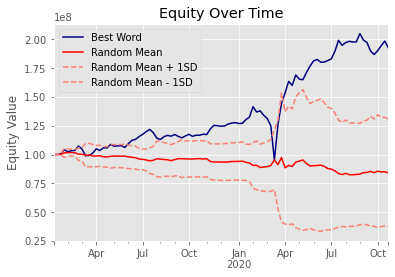

In [421]:
best_stat = testing_stats[best_word]
best = best_stat["_equity_curve"]['Equity'].plot(color='navy', label="Best Word")

mean = random_rolling_mean_and_sd['mean'].plot(color='r', label = 'Random Mean')
mean_plus = (random_rolling_mean_and_sd['mean']+random_rolling_mean_and_sd["sd"]).plot(color='salmon', label = 'Random Mean + 1SD', linestyle='dashed')
mean_minus = (random_rolling_mean_and_sd['mean']-random_rolling_mean_and_sd["sd"]).plot(color='salmon', label = 'Random Mean - 1SD', linestyle='dashed')

plt.ylabel('Equity Value')
plt.legend()
x=plt.title('Equity Over Time')